<a href="https://colab.research.google.com/github/Yarrieta/Entregas_PNL/blob/Desafio3/3_modelo_lenguaje_char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [3]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el año 1872, la casa número 7 de saville-row, burlington gardens \r\n—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a\r\n pesar de que parecía haber tomado el partido de no hacer nada que \r\npudiese llamar la atención, era uno de los miembros más notables y \r\nsingulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo \r\nse sabía que era un hombre muy galante y de los más cumplidos gentlemen \r\nde la alta sociedad inglesa, sucedía a uno de los más grandes oradores \r\nque honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende, \r\nporque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron \r\nde bigote y pastillas, a un byron impasible, que hubiera vivido mil años\r\n sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en\r\n londres. jamás se le había visto en la bolsa ni en el banco, ni en \r\nninguno de los despachos mercantiles de 

In [5]:
article_text = article_text.replace('\n',' ')
article_text = article_text.replace('\r',' ')

In [6]:
# en article text se encuentra el texto de todo el libro
article_text[:3000]

" en el año 1872, la casa número 7 de saville-row, burlington gardens   —donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a   pesar de que parecía haber tomado el partido de no hacer nada que   pudiese llamar la atención, era uno de los miembros más notables y   singulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo   se sabía que era un hombre muy galante y de los más cumplidos gentlemen   de la alta sociedad inglesa, sucedía a uno de los más grandes oradores   que honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende,   porque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron   de bigote y pastillas, a un byron impasible, que hubiera vivido mil años   sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en   londres. jamás se le había visto en la bolsa ni en el banco, ni en   ninguno de los despachos mercantiles de la city. ni las dársenas

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [9]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

66

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [12]:
char2idx

{',': 0,
 'g': 1,
 '\t': 2,
 '¡': 3,
 '7': 4,
 'w': 5,
 'a': 6,
 '<': 7,
 'd': 8,
 'ó': 9,
 '.': 10,
 '5': 11,
 'í': 12,
 'ü': 13,
 't': 14,
 '-': 15,
 '(': 16,
 '2': 17,
 'p': 18,
 '1': 19,
 'f': 20,
 ';': 21,
 '6': 22,
 '"': 23,
 '»': 24,
 'j': 25,
 'e': 26,
 'k': 27,
 'o': 28,
 'u': 29,
 '4': 30,
 'y': 31,
 '0': 32,
 ')': 33,
 'è': 34,
 'é': 35,
 '«': 36,
 'l': 37,
 'm': 38,
 '¿': 39,
 '~': 40,
 'ñ': 41,
 '—': 42,
 ' ': 43,
 '3': 44,
 'v': 45,
 'r': 46,
 'z': 47,
 "'": 48,
 'h': 49,
 '8': 50,
 's': 51,
 '9': 52,
 'n': 53,
 'x': 54,
 '/': 55,
 'c': 56,
 'q': 57,
 ':': 58,
 '?': 59,
 'ú': 60,
 '!': 61,
 'b': 62,
 'á': 63,
 '>': 64,
 'i': 65}

###  Tokenizar

In [11]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [14]:
tokenized_text[:1000]

[43,
 26,
 53,
 43,
 26,
 37,
 43,
 6,
 41,
 28,
 43,
 19,
 50,
 4,
 17,
 0,
 43,
 37,
 6,
 43,
 56,
 6,
 51,
 6,
 43,
 53,
 60,
 38,
 26,
 46,
 28,
 43,
 4,
 43,
 8,
 26,
 43,
 51,
 6,
 45,
 65,
 37,
 37,
 26,
 15,
 46,
 28,
 5,
 0,
 43,
 62,
 29,
 46,
 37,
 65,
 53,
 1,
 14,
 28,
 53,
 43,
 1,
 6,
 46,
 8,
 26,
 53,
 51,
 43,
 43,
 43,
 42,
 8,
 28,
 53,
 8,
 26,
 43,
 38,
 29,
 46,
 65,
 9,
 43,
 51,
 49,
 26,
 46,
 65,
 8,
 6,
 53,
 43,
 26,
 53,
 43,
 19,
 50,
 19,
 30,
 42,
 43,
 26,
 51,
 14,
 6,
 62,
 6,
 43,
 49,
 6,
 62,
 65,
 14,
 6,
 8,
 6,
 43,
 18,
 28,
 46,
 43,
 18,
 49,
 65,
 37,
 26,
 6,
 51,
 43,
 20,
 28,
 1,
 1,
 0,
 43,
 57,
 29,
 65,
 26,
 53,
 43,
 6,
 43,
 43,
 43,
 18,
 26,
 51,
 6,
 46,
 43,
 8,
 26,
 43,
 57,
 29,
 26,
 43,
 18,
 6,
 46,
 26,
 56,
 12,
 6,
 43,
 49,
 6,
 62,
 26,
 46,
 43,
 14,
 28,
 38,
 6,
 8,
 28,
 43,
 26,
 37,
 43,
 18,
 6,
 46,
 14,
 65,
 8,
 28,
 43,
 8,
 26,
 43,
 53,
 28,
 43,
 49,
 6,
 56,
 26,
 46,
 43,
 53,
 6,
 8,
 6,
 43,
 57,


### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [20]:
X.shape

(359671, 100)

In [21]:
X[0,:10]

array([43, 26, 53, 43, 26, 37, 43,  6, 41, 28])

In [22]:
y[0,:10]

array([26, 53, 43, 26, 37, 43,  6, 41, 28, 43])

In [17]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [18]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [25]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          53,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 66)            │          13,266 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,666 (260.41 KB)

 Trainable params: 66,666 (260.41 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [19]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [27]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 2.4320
 mean perplexity: 6.408834478300257 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 643s 451ms/step - loss: 2.4318
Epoch 2/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 1.9241
 mean perplexity: 5.5517679191772515 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 641s 457ms/step - loss: 1.9241
Epoch 3/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 1.8181
 mean perplexity: 5.235141046918059 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 609s 434ms/step - loss: 1.8180
Epoch 4/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 1.7694
 mean perplexity: 5.136374881789337 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 629s 439ms/step - loss: 1.7694
Epoch 5/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 1.7429
 mean perplexity: 4.977523756802655 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 616s 439ms/step - loss: 1.7429
Epoch 6/20
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - l

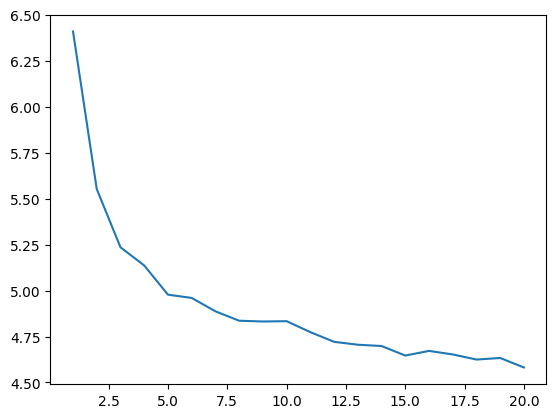

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [29]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [30]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

#sentencia= de los más cumplidos gentlemen de la alta sociedad [inglesa]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.5 MB/s eta 0:00:00


In [50]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://0d915e1f5b51b52632.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0d915e1f5b51b52632.gradio.live


### Generación de secuencias

In [35]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [52]:
#la casa número 7 de saville
input_text='de los más cumplidos gentlemen de la alta sociedad'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'de los más cumplidos gentlemen de la alta sociedad de la cabeza de la cabeza de '

###  Beam search y muestreo aleatorio

In [40]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [41]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [55]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="de los más cumplidos gentlemen de la alta sociedad")

In [56]:
salidas[0]

array([ 8, 26, 43, 37, 28, 51, 43, 38, 63, 51, 43, 56, 29, 38, 18, 37, 65,
        8, 28, 51, 43,  1, 26, 53, 14, 37, 26, 38, 26, 53, 43,  8, 26, 43,
       37,  6, 43,  6, 37, 14,  6, 43, 51, 28, 56, 65, 26,  8,  6,  8, 43,
        8, 26, 43, 37,  6, 43, 26, 51, 14,  6, 56, 65,  9, 53, 43,  8, 26,
       43, 37])

In [57]:
# veamos las salidas
decode(salidas[0])

'de los más cumplidos gentlemen de la alta sociedad de la estación de l'

In [58]:
#veamos las salidas
decode(salidas[1])

'de los más cumplidos gentlemen de la alta sociedad de los viajeros de '

In [59]:
#veamos las salidas
decode(salidas[2])

'de los más cumplidos gentlemen de la alta sociedad de la estación del '

In [60]:
#veamos las salidas
decode(salidas[3])

'de los más cumplidos gentlemen de la alta sociedad de la estación de p'

In [61]:
#veamos las salidas
decode(salidas[4])

'de los más cumplidos gentlemen de la alta sociedad de picaporte se hab'

In [62]:
#veamos las salidas
decode(salidas[5])

'de los más cumplidos gentlemen de la alta sociedad de picaporte, que n'

In [63]:
#veamos las salidas
decode(salidas[6])

'de los más cumplidos gentlemen de la alta sociedad de la estación de  '

In [64]:
#veamos las salidas
decode(salidas[7])

'de los más cumplidos gentlemen de la alta sociedad de la estación de s'

In [65]:
#veamos las salidas
decode(salidas[8])

'de los más cumplidos gentlemen de la alta sociedad de picaporte, que e'

In [66]:
#veamos las salidas
decode(salidas[9])

'de los más cumplidos gentlemen de la alta sociedad de los viajeros en '

### MODELO CON GRU

In [20]:
model_gru = Sequential()

model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 200)           │         160,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 66)            │          13,266 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,066 (679.95 KB)

 Trainable params: 174,066 (679.95 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model_gru.fit(X, y, epochs=15, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 2.4973
 mean perplexity: 6.286812855516326 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1438s 1s/step - loss: 2.4971
Epoch 2/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - loss: 1.8729
 mean perplexity: 5.069012630550833 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1408s 982ms/step - loss: 1.8729
Epoch 3/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - loss: 1.7037
 mean perplexity: 4.61116362038159 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1428s 1s/step - loss: 1.7037
Epoch 4/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - loss: 1.6259
 mean perplexity: 4.439326498376672 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1479s 1s/step - loss: 1.6259
Epoch 5/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - loss: 1.5808
 mean perplexity: 4.334212827479653 

Saved new model!
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1475s 1s/step - loss: 1.5808
Epoch 6/15
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - loss: 1.55

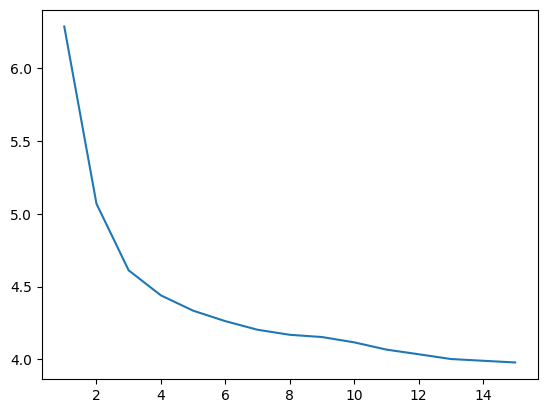

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [33]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

In [34]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [37]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://906e8f9956beddabda.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://906e8f9956beddabda.gradio.live


In [38]:
input_text='no formaba parte ni del instituto real de la gran bretañ'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'no formaba parte ni del instituto real de la gran bretaña de la compañía de la compañí'

In [58]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=15,input="este gentleman no figuraba en ningún comité de administració",temp=1,mode='sto')

In [59]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 75)

In [60]:
# veamos las salidas
decode(salidas[0])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [61]:
# veamos las salidas
decode(salidas[1])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [62]:
# veamos las salidas
decode(salidas[2])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [63]:
# veamos las salidas
decode(salidas[3])

'este gentleman no figuraba en ningún comité de administración de los viajer'

In [64]:
# veamos las salidas
decode(salidas[4])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [65]:
# veamos las salidas
decode(salidas[5])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [66]:
# veamos las salidas
decode(salidas[6])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [67]:
# veamos las salidas
decode(salidas[7])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [68]:
# veamos las salidas
decode(salidas[8])

'este gentleman no figuraba en ningún comité de administración de la estació'

In [69]:
# veamos las salidas
decode(salidas[9])

'este gentleman no figuraba en ningún comité de administración de la estació'

* Se observa que el modelo GRU tiene mejor desempeño con 15 épocas con respecto a Simple RNN con 20 épocas. En el modelo GRU se observa que se completa correctamente el carácter faltante.